In [1]:
# !pip install torch==1.11.0+cpu torchvision==0.12.0+cpu torchaudio==0.11.0+cpu -f https://download.pytorch.org/whl/cpu/torch_stable.html
# !pip install functorch

# print("--> Restarting colab instance") 
# get_ipython().kernel.do_shutdown(True)

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms

from torchmetrics import Accuracy

import wandb

import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [2]:
wandb.init(project="functorch-examples")

config = wandb.config
config.batch_size = 64
config.num_workers = 2
config.learning_rate = 1e-2
config.epochs = 5
config.artifact_address = 'geekyrakshit/functorch-examples/cifar-10:v0'
config.device = "cuda:0" if torch.cuda.is_available() else "cpu"
config.classes = (
    'plane', 'car', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: geekyrakshit (use `wandb login --relogin` to force relogin)


In [3]:
artifact = wandb.use_artifact(config.artifact_address, type='dataset')
artifact_dir = artifact.download()

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
    )
])

train_dataset = torchvision.datasets.CIFAR10(
    root=artifact_dir, train=True,
    download=False, transform=transform
)
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=config.batch_size,
    shuffle=True, num_workers=config.num_workers
)

test_dataset = torchvision.datasets.CIFAR10(
    root=artifact_dir, train=False,
    download=False, transform=transform
)
test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=config.batch_size,
    shuffle=False, num_workers=config.num_workers
)

wandb: Downloading large artifact cifar-10:v0, 340.19MB. 9 files... Done. 0:0:0


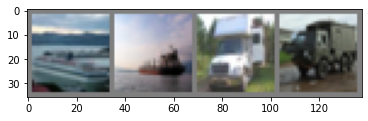

ship  ship  truck truck


In [4]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


dataiter = iter(train_loader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images[0:4]))
print(' '.join(f'{config.classes[labels[j]]:5s}' for j in range(4)))

In [5]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [6]:
def to_device(tensors, device="cpu"):
    "Put tensors on device"
    if isinstance(tensors, (list, tuple)):
        return tuple(to_device(t, device) for t in tensors)
    elif isinstance(tensors, torch.Tensor):
        return tensors.to(device)
    else:
        raise Exception("Not a torch tensor-ish")

## Stateful PyTorch

In [7]:
model = Classifier().to(config.device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)
metric = Accuracy().to(config.device)

In [8]:
for epoch in tqdm(range(config.epochs)):  # loop over the dataset multiple times
    metric.reset()
    running_loss = 0.0
    for i, data in tqdm(enumerate(train_loader), total=len(train_loader), leave=False):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = to_device(data, config.device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        acc = metric(outputs, labels)

        # print statistics
        running_loss += loss.item()
    print(f'[{epoch}] loss: {running_loss / 2000:.3f}, accuracy: {metric.compute():.3f}')
    wandb.log({
        "loss": running_loss,
        "accuracy": metric.compute()
    })

print('Finished Training')

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

[0] loss: 0.712, accuracy: 0.316


  0%|          | 0/782 [00:00<?, ?it/s]

[1] loss: 0.651, accuracy: 0.378


  0%|          | 0/782 [00:00<?, ?it/s]

[2] loss: 0.631, accuracy: 0.400


  0%|          | 0/782 [00:00<?, ?it/s]

[3] loss: 0.618, accuracy: 0.417


  0%|          | 0/782 [00:00<?, ?it/s]

[4] loss: 0.610, accuracy: 0.426
Finished Training


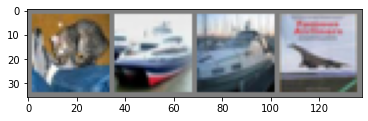

ship/cat   ship/ship  ship/ship  ship/plane


In [9]:
batch = next(iter(test_dataloader))
images, labels = to_device(batch, config.device)
preds = model(images).argmax(axis=1)
images, preds, labels = to_device([images, preds, labels], device="cpu")
imshow(torchvision.utils.make_grid(images[0:4]))
print(' '.join(f'{config.classes[preds[j]]}/{config.classes[labels[j]]:5s}' for j in range(4)))

# Functional PyTorch

In [7]:
from functorch import make_functional, grad_and_value

In [8]:
model = Classifier().to(device=config.device)
functional_model, params = make_functional(model)
metric = Accuracy().to(config.device)

In [9]:
def sgd_optimizer(weights, gradients, learning_rate):
    """Naive SGD implementation"""

    def step(weight, gradient):
        return weight - learning_rate * gradient

    return [step(weight, gradient) for weight, gradient in zip(weights, gradients)]

In [10]:
def compute_stateless_loss(params, inputs, labels):
    outputs = functional_model(params, inputs)
    loss = F.cross_entropy(outputs, labels)
    return loss

compute_gradients = grad_and_value(compute_stateless_loss)

In [11]:
def functional_step(params, inputs, labels):
    gradients, loss = compute_gradients(params, inputs, labels)
    params = sgd_optimizer(params, gradients, config.learning_rate)
    return params, loss

In [12]:
def train(functional_step, params, metric):
    running_loss = 0.
    metric.reset()
    for i, data in tqdm(enumerate(train_loader), total=len(train_loader), leave=False):
        inputs, labels = to_device(data, config.device)
        params, loss = functional_step(params, inputs, labels)
        running_loss += loss.item()
        
        # new forward
        outputs = functional_model(params, inputs)
        metric(outputs, labels)
        
    return params, running_loss, metric

In [13]:
for epoch in tqdm(range(config.epochs)):
    params, running_loss, metric = train(functional_step, params, metric)
    print(f'[{epoch}] loss: {running_loss / 2000:.3f}, accuracy: {metric.compute():.3f}')
    wandb.log({
        "loss": running_loss,
        "accuracy": metric.compute()
    })

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

[0] loss: 0.899, accuracy: 0.133


  0%|          | 0/782 [00:00<?, ?it/s]

[1] loss: 0.849, accuracy: 0.228


  0%|          | 0/782 [00:00<?, ?it/s]

[2] loss: 0.738, accuracy: 0.339


  0%|          | 0/782 [00:00<?, ?it/s]

[3] loss: 0.661, accuracy: 0.413


  0%|          | 0/782 [00:00<?, ?it/s]

[4] loss: 0.624, accuracy: 0.450


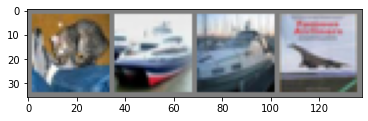

cat/cat   ship/ship  car/ship  ship/plane


In [14]:
batch = next(iter(test_dataloader))
images, labels = to_device(batch, config.device)
preds = functional_model(params, images).argmax(axis=1)
images, preds, labels = to_device([images, preds, labels], device="cpu")
imshow(torchvision.utils.make_grid(images[0:4]))
print(' '.join(f'{config.classes[preds[j]]}/{config.classes[labels[j]]:5s}' for j in range(4)))

In [15]:
wandb.finish()

accuracy,▁▃▆▇█
loss,█▇▄▂▁
accuracy,0.4501
loss,1247.18743
